<div align="center" style="font-size: 24px; font-weight: bold;">Electrical and Computer Engineering Department</div>
<div align="center" style="font-size: 18px;font-weight: bold;">First Semester, 2023/2024</div>
<div align="center" style="font-size: 20px; font-weight: bold;">Intelligent Systems Lab ‐ ENCS5141</div>
<div align="center" style="font-size: 18px; font-weight: bold;">Assignment #4</div>
<hr>
<div align="center" style="font-size: 16px;">Prepared by: Mohammad AbuJaber</div>
<div align="center" style="font-size: 16px;">ID: 1190298</div>
<div align="center" style="font-size: 16px;">Instructor: Dr. Mohammad Jubran</div>
<div align="center" style="font-size: 16px;">Assistant's Name: Eng. Hanan Awawdeh</div>
<div align="center" style="font-size: 16px;">Section: 3</div>
<div align="center" style="font-size: 16px;">Date: 23rd January 2024</div>
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
ID = 1190298 # 1ABCDYX
ABC = 190
D = 2
Y = 9
X = 8

In [3]:
def binary_label_transform(label):
    return 1 if label > 4.2857 else 0

In [4]:
class BinaryMNISTDataset(Dataset):
    def __init__(self, mnist_dataset, transform=None):
        self.mnist_dataset = mnist_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, label = self.mnist_dataset[idx]
        binary_label = self.transform(label)
        return img, binary_label

# MNIST Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
binary_transformed_dataset = BinaryMNISTDataset(mnist_dataset, transform=binary_label_transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(binary_transformed_dataset))
test_size = len(binary_transformed_dataset) - train_size
train_dataset, test_dataset = random_split(binary_transformed_dataset, [train_size, test_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 50424322.66it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40690525.30it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28746145.42it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9430954.84it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, X + 4, kernel_size=3)
        self.pool1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(X + 4, Y + 15, kernel_size=3)
        self.pool2 = nn.AvgPool2d(2, stride=2)
        self.fc1 = nn.Linear((Y + 15) * 5 * 5, ABC)
        self.fc2 = nn.Linear(ABC, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

net = BinaryCNN()

# 1- Train the model specified above on GPU for 3 epochs using Adam optimizer with learning rate 0.0005 and batch size 8.

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

cuda:0


BinaryCNN(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=600, out_features=190, bias=True)
  (fc2): Linear(in_features=190, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [7]:
# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# Training loop
num_epochs = 3
training_accuracy = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predictions == labels.view(-1, 1)).sum().item()

    training_accuracy.append(100 * correct_train / total_train)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_dataloader):.3f} '
          f'Training Accuracy: {100 * correct_train / total_train:.2f}%')

print('Finished Training')

Epoch [1/3] Loss: 0.138 Training Accuracy: 94.49%
Epoch [2/3] Loss: 0.050 Training Accuracy: 98.26%
Epoch [3/3] Loss: 0.036 Training Accuracy: 98.79%
Finished Training


# 2- Plot the training accuracy vs. epoch curve.

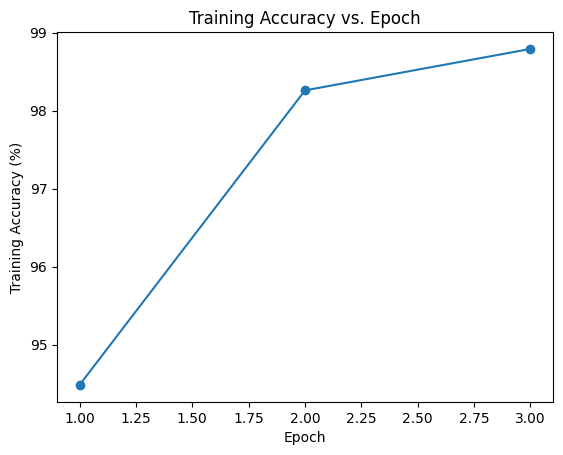

In [8]:
# Plot training accuracy vs. epoch curve
plt.plot(range(1, num_epochs + 1), training_accuracy, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy vs. Epoch')
plt.show()

# 3- Compute the testing accuracy of the learned model.

In [9]:
# Testing accuracy
correct_test = 0
total_test = 0

net.eval()
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.float().to(device)

        outputs = net(images)
        predictions = (outputs > 0.5).float()
        total_test += labels.size(0)
        correct_test += (predictions == labels.view(-1, 1)).sum().item()

print(f'Testing Accuracy: {100 * correct_test / total_test:.2f}%')

Testing Accuracy: 98.72%


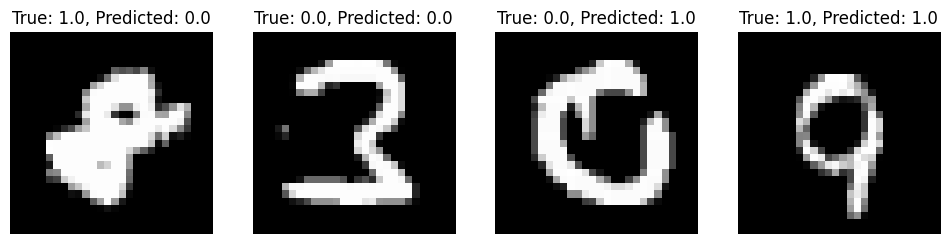

In [20]:
# Plot misclassified images
misclassified_images = []
correct_labels = []
predicted_labels = []

net.eval()
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.float().to(device)

        outputs = net(images)
        predictions = (outputs > 0.5).float()

        misclassified_mask = predictions != labels.view(-1, 1)

        # Extracting misclassified indices
        misclassified_indices = torch.nonzero(misclassified_mask).reshape(-1)

        # Using misclassified indices to extract corresponding images, correct labels, and predicted labels
        misclassified_images.extend(images[misclassified_indices])
        correct_labels.extend(labels[misclassified_indices].cpu().numpy())
        predicted_labels.extend(predictions[misclassified_indices].cpu().numpy())

# Display 4 misclassified images
num_misclassified = min(4, len(misclassified_images))
fig, axes = plt.subplots(1, num_misclassified, figsize=(12, 3))

for i in range(num_misclassified):
    axes[i].imshow(misclassified_images[i][0].cpu().numpy(), cmap='gray')
    axes[i].set_title(f'True: {correct_labels[i]}, Predicted: {predicted_labels[i][0]}')
    axes[i].axis('off')

plt.show()
